In [1]:
# %% ========================================
# 0. ライブラリ & データ読み込み
# ========================================
import pandas as pd
import numpy as np
import os

# 01_exploration の出力を読み込み
VALID_PATH = "/home/jovyan/work/data/interim/df_valid.parquet"
df_valid = pd.read_parquet(VALID_PATH)
print(f"✅ Loaded valid data: {df_valid.shape[0]} rows, {df_valid['athlete_name'].nunique()} athletes")

✅ Loaded valid data: 66950 rows, 57 athletes


In [2]:
# %% ========================================
# 1. 日次集計：選手 × 日付 単位に変換
# ========================================
daily_features = ["total_distance", "total_player_load", "mean_heart_rate"]
agg_funcs = {col: "mean" for col in daily_features}
agg_funcs.update({"session_duration_sec": "sum"})

df_daily = (
    df_valid.groupby(["athlete_name", "date_"])
    .agg(agg_funcs)
    .reset_index()
    .sort_values(["athlete_name", "date_"])
)

print("✅ 日次集計完了")
print(df_daily.head())


✅ 日次集計完了
  athlete_name      date_  total_distance  total_player_load  mean_heart_rate  \
0   Asahi YADA 2024-01-12     1006.363205         114.695892        98.472747   
1   Asahi YADA 2024-01-13      859.911758         101.572553       127.201588   
2   Asahi YADA 2024-01-18      586.916458          72.913979        94.724526   
3   Asahi YADA 2024-01-19     1012.365682         121.149218        81.834778   
4   Asahi YADA 2024-01-20     4119.961430         475.533660        77.995880   

   session_duration_sec  
0                4034.0  
1                3590.0  
2                6642.0  
3                5308.0  
4                1823.0  


In [3]:
# %% ========================================
# 2. ACWR（EWMA版）計算関数群
# ========================================
def compute_acwr_ewma(series, acute_span=7, chronic_span=28):
    """
    EWMAを用いたACWR（急性／慢性負荷比）を計算
    ※初期（慢性期間内）はNaN化して精度を担保
    """
    acute = series.ewm(span=acute_span, adjust=False).mean()
    chronic = series.ewm(span=chronic_span, adjust=False).mean()
    acwr = acute / chronic
    acwr.iloc[:chronic_span] = np.nan
    return acwr

def add_acwr_features(df, var, acute=7, chronic=28):
    """
    指定した変数(var)に対して、ACWR/EWMA系列の特徴量をまとめて生成
    """
    g = df.groupby("athlete_name")[var]
    df[f"EWMA{acute}_{var}"] = g.transform(lambda s: s.ewm(span=acute, adjust=False).mean())
    df[f"EWMA{chronic}_{var}"] = g.transform(lambda s: s.ewm(span=chronic, adjust=False).mean())
    df[f"ACWR_EWMA_{var}"] = g.transform(lambda s: compute_acwr_ewma(s, acute, chronic))
    df[f"EWMA_ratio_{var}"] = df[f"EWMA{acute}_{var}"] / df[f"EWMA{chronic}_{var}"]
    return df

In [4]:
# %% ========================================
# 3. 特徴量生成の実行
# ========================================
target_vars = ["total_distance", "total_player_load"]

for var in target_vars:
    df_daily = add_acwr_features(df_daily, var)

print("✅ ACWR・EWMA系列特徴量を追加しました！")
display(df_daily.filter(regex="ACWR|EWMA").head())

✅ ACWR・EWMA系列特徴量を追加しました！


,EWMA7_total_distance,EWMA28_total_distance,ACWR_EWMA_total_distance,EWMA_ratio_total_distance,EWMA7_total_player_load,EWMA28_total_player_load,ACWR_EWMA_total_player_load,EWMA_ratio_total_player_load
0,1006.363205,1006.363205,NaN,1.000000,114.695892,114.695892,NaN,1.000000
1,969.750343,996.263105,NaN,0.973388,111.415057,113.790835,NaN,0.979122
2,874.041872,968.032302,NaN,0.902906,101.789788,110.971741,NaN,0.917259
3,908.622824,971.089776,NaN,0.935673,106.629646,111.673636,NaN,0.954833
4,1711.457476,1188.253339,NaN,1.440314,198.855649,136.767431,NaN,1.453969


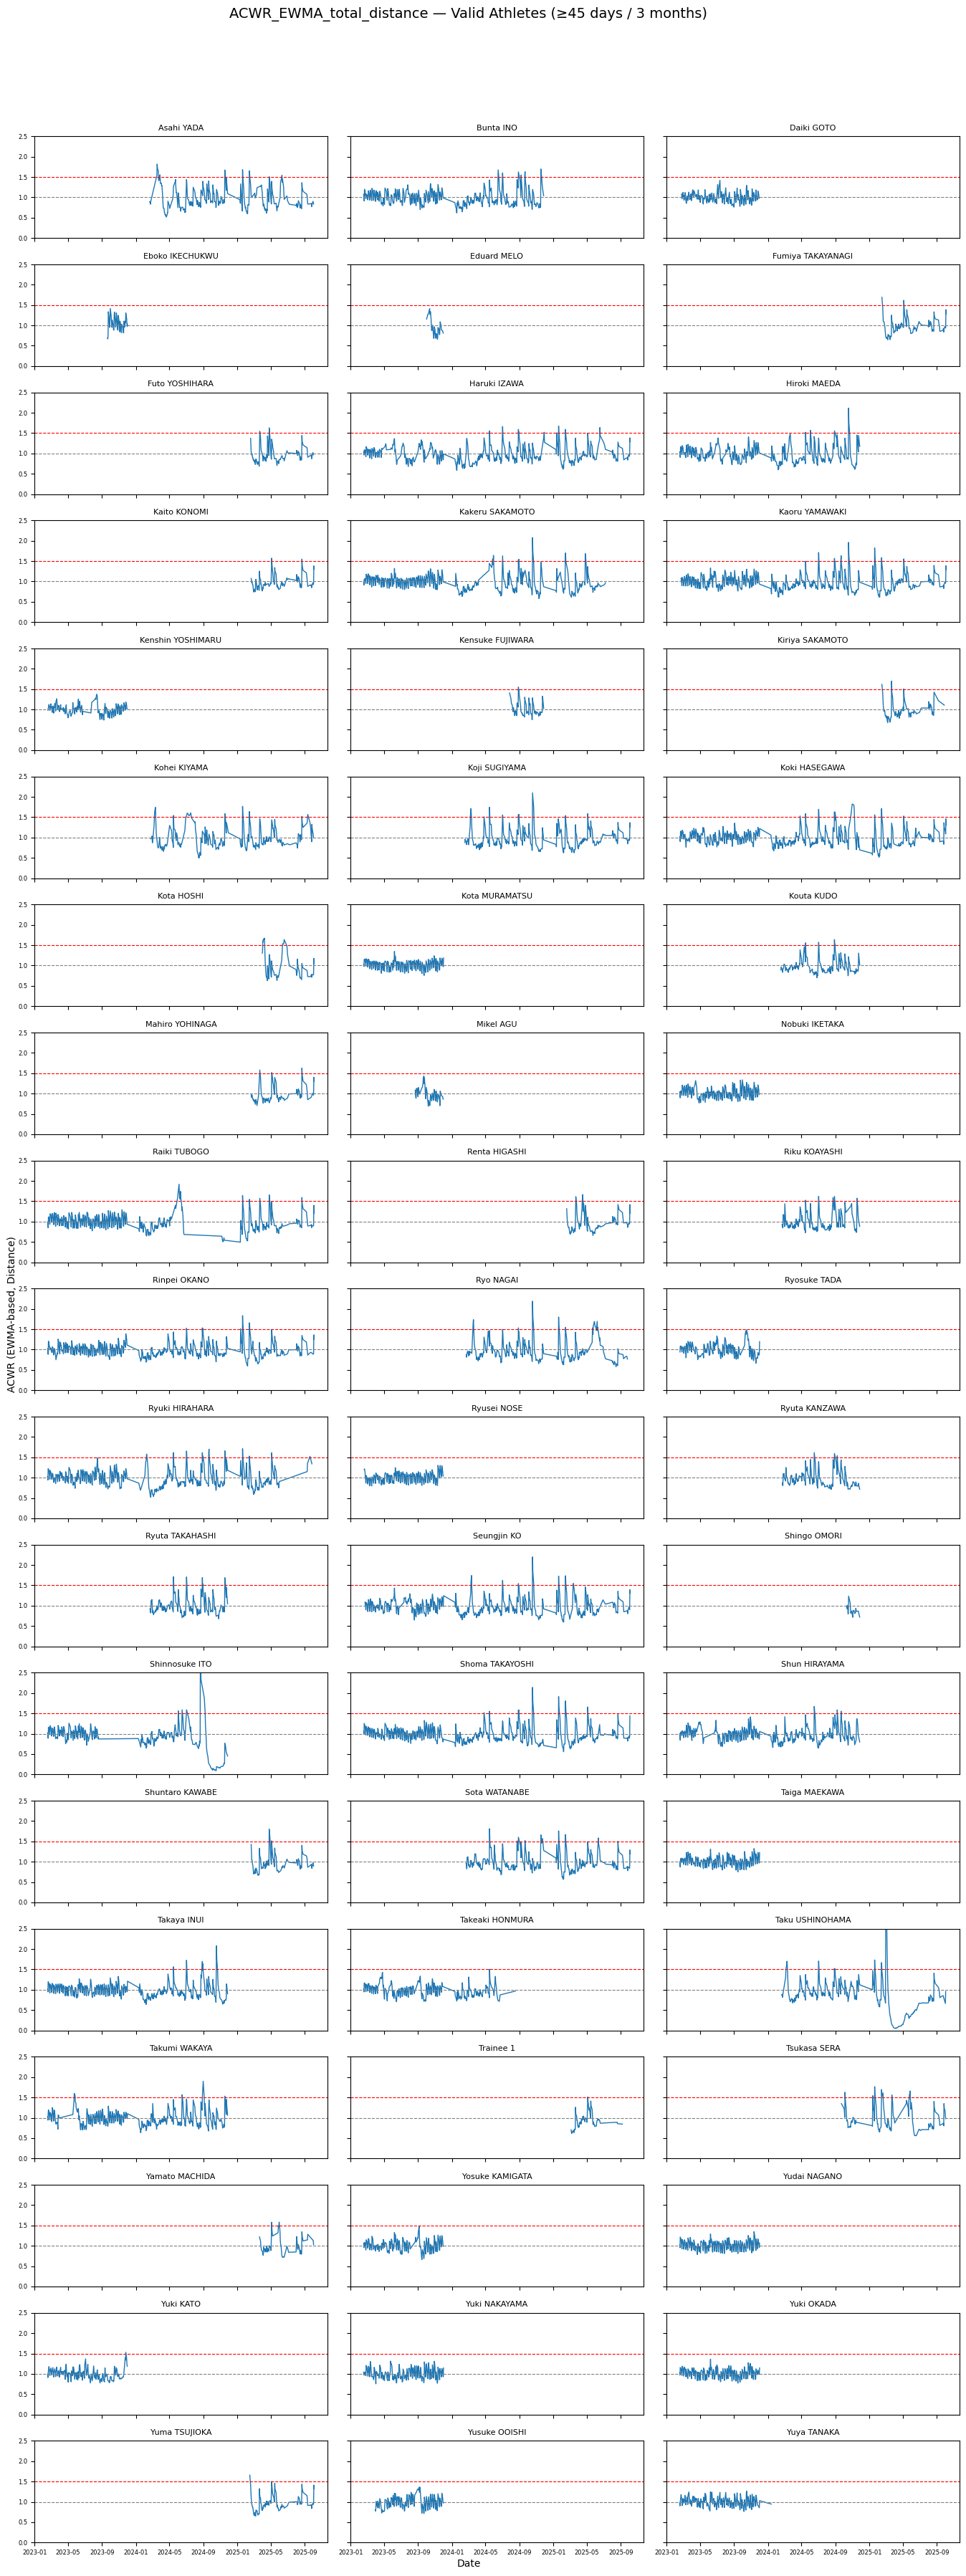

In [5]:
# %% ========================================
# 4. 可視化：ACWR_EWMA_distance の推移（確認）
# ========================================
import matplotlib.pyplot as plt
import math

players = df_daily["athlete_name"].unique()
cols = 3
rows = math.ceil(len(players) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 2.0), sharex=True, sharey=True)
axes = axes.flatten()

for i, player in enumerate(players):
    ax = axes[i]
    sub = df_daily[df_daily["athlete_name"] == player]
    ax.plot(sub["date_"], sub["ACWR_EWMA_total_distance"], color="tab:blue", linewidth=1)
    ax.axhline(1.0, color="gray", linestyle="--", linewidth=0.8)
    ax.axhline(1.5, color="red", linestyle="--", linewidth=0.8)
    ax.set_title(player, fontsize=8)
    ax.set_ylim(0, 2.5)
    ax.tick_params(axis="x", labelsize=6)
    ax.tick_params(axis="y", labelsize=6)

# 余白削除
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("ACWR_EWMA_total_distance — Valid Athletes (≥45 days / 3 months)", fontsize=14)
fig.text(0.5, 0.04, "Date", ha="center")
fig.text(0.04, 0.5, "ACWR (EWMA-based, Distance)", va="center", rotation="vertical")
plt.tight_layout(rect=[0.04, 0.04, 1, 0.95])
plt.show()

In [6]:
# %% ========================================
# 5. 保存（次ノートブックで使用）
# ========================================
INTERIM_DIR = "/home/jovyan/work/data/interim"
os.makedirs(INTERIM_DIR, exist_ok=True)

DAILY_PATH = os.path.join(INTERIM_DIR, "df_daily.parquet")
df_daily.to_parquet(DAILY_PATH, index=False)

print(f"💾 Saved daily features: {DAILY_PATH}")
print("👉 次のノートブック（03_anomaly_detection.ipynb）ではこの df_daily.parquet を使用します。")

💾 Saved daily features: /home/jovyan/work/data/interim/df_daily.parquet
👉 次のノートブック（03_anomaly_detection.ipynb）ではこの df_daily.parquet を使用します。


In [7]:
# ========================================
# 特徴量候補の一覧（03で静的異常検知用）
# ========================================

print("📌 利用可能な特徴量一覧（df_daily columns）\n")
cols = sorted(df_daily.columns)
for c in cols:
    print("-", c)


📌 利用可能な特徴量一覧（df_daily columns）

- ACWR_EWMA_total_distance
- ACWR_EWMA_total_player_load
- EWMA28_total_distance
- EWMA28_total_player_load
- EWMA7_total_distance
- EWMA7_total_player_load
- EWMA_ratio_total_distance
- EWMA_ratio_total_player_load
- athlete_name
- date_
- mean_heart_rate
- session_duration_sec
- total_distance
- total_player_load


In [8]:
# ========================================
# データ量が最も多い選手を特定（03で使用）
# ========================================

player_days = (
    df_daily.groupby("athlete_name")["date_"]
    .nunique()
    .sort_values(ascending=False)
)

print("\n🎯 データ日数ランキング")
print(player_days)

top_player = player_days.index[0]
print(f"\n👉 最多データ選手: {top_player} ({player_days.iloc[0]} days)")

df_focus = df_daily[df_daily["athlete_name"] == top_player].sort_values("date_")



🎯 データ日数ランキング
athlete_name
Kaoru YAMAWAKI       623
Shoma TAKAYOSHI      611
Rinpei OKANO         607
Koki HASEGAWA        603
Seungjin KO          595
Haruki IZAWA         572
Ryuki HIRAHARA       568
Raiki TUBOGO         527
Kakeru SAKAMOTO      519
Bunta INO            476
Takaya INUI          448
Hiroki MAEDA         441
Shun HIRAYAMA        440
Takumi WAKAYA        439
Sota WATANABE        369
Shinnosuke ITO       367
Koji SUGIYAMA        356
Taku USHINOHAMA      346
Asahi YADA           335
Ryo NAGAI            331
Takeaki HONMURA      328
Kohei KIYAMA         321
Yuki NAKAYAMA        254
Yuya TANAKA          251
Taiga MAEKAWA        248
Nobuki IKETAKA       247
Daiki GOTO           242
Yudai NAGANO         241
Yuki OKADA           238
Ryusei NOSE          237
Yosuke KAMIGATA      237
Kota MURAMATSU       236
Yuki KATO            235
Ryosuke TADA         234
Ryuta TAKAHASHI      231
Yusuke OOISHI        215
Kouta KUDO           210
Riku KOAYASHI        210
Kenshin YOSHIMARU    20